# CMRM Assignment No. 2

In [29]:
import os
import numpy as np
import soundfile as sf
import librosa
import sklearn # pip install sklearn
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm # pip install tqdm
from nmf import nmf

## Question 1

In [30]:
## Define directories and lists based on provided code structure
output_dir = "audio/results"
source_dir = "audio/audio/sources"
target_dir = "audio/audio/targets"
sources = ["Bees_Buzzing.mp3", "Wind_Blowing.mp3", "Chainsaw_Sawing.mp3"]
targets = ["Jingle_Bells_Boogie.wav", "Have_Yourself.wav", "Blue_Christmas.wav", "White_Christmas.wav"]

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)


# Define the source and target variables using the respective lists
source = sources[0]  # Selecting "Bees Buzzing.wav" from the sources list
target = targets[0]  # Selecting "Jingle Bells Boogie.wav" from the targets list


In [31]:
## Load signals
Fs = 22050

# Load the source and target waveforms
source_path = os.path.join(source_dir, source)
target_path = os.path.join(target_dir, target)

# Load audio files
source_waveform, _ = librosa.load(source_path, sr=Fs)
target_waveform, _ = librosa.load(target_path, sr=Fs)



Dimension of Ytarget:(2049, 1113)


(0.046439909297052155, 5.38330078125)

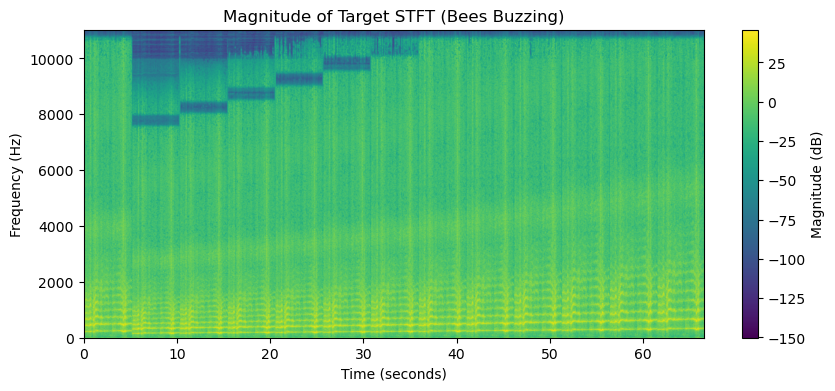

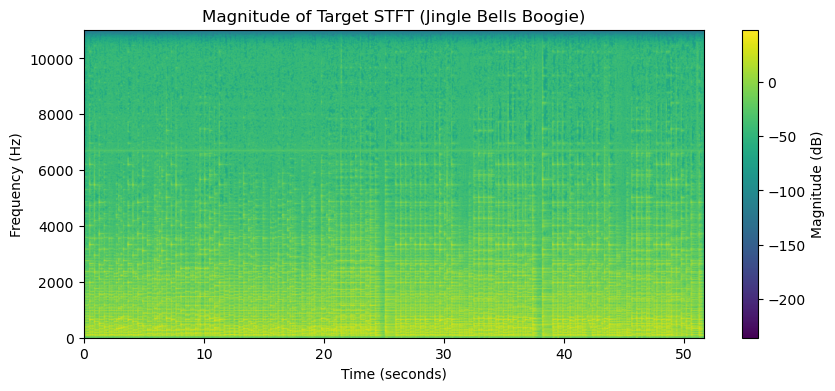

In [54]:
## Define sampling frequency and STFT parameters
N_length = 4096
H_size = 1024

## Compute the STFT of the source waveform
X_source = librosa.stft(source_waveform, n_fft=N_length, hop_length=H_size)

# Extract the magnitude of the source STFT
Y_source = np.abs(X_source)

eps= np.finfo(float).eps
Y_source_db = 20*np.log10(Y_source + eps)
#Y_source_db = np.log10(1 + 10* Y_source)

time_axis= np.arange(X_source.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_source.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]+y_ext]
    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Bees Buzzing)")
plt.imshow(Y_source_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')




# Compute the STFT of the target waveform
X_target = librosa.stft(target_waveform, n_fft=N_length, hop_length=H_size)
# Extract the magnitude of the target STFT

Y_target = np.abs(X_target)
Y_target_db = 20 * np.log10(Y_target + eps)

time_axis= np.arange(X_target.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_target.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]+y_ext]
    
# Plot the magnitude of the target STFT    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Jingle Bells Boogie)")
plt.imshow(Y_target_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

print(f"Dimension of Ytarget:{Y_target.shape}")

# Compute time resolution and frequency resolution
time_res = H_size / Fs  # Time resolution in seconds
freq_res = Fs / N_length  # Frequency resolution in Hz


time_res, freq_res

## Source


## Plot

## Target

## Plot


## Question 2

In [52]:
from nmf import nmf  # Funzione NMF dal file nmf.py

# 1. Inizializzazione della matrice di attivazione H0 con valori casuali
np.random.seed(42)  # Per riproducibilità
H0 = np.random.rand(X_source.shape[1], X_target.shape[1])  # Dimensioni temporali di X_source e X_target
print(f"Dimension of H0:{H0.shape}")
# 2. Inizializzazione della matrice template W0 normalizzata
W0 = Y_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Divisione Hadamard (element-wise)
print(f"Dimension of W0:{W0.shape}")
# 3. Definizione di Xs (normalizzazione della STFT sorgente)
Xs = X_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Divisione Hadamard
print(f"Dimension of Xs:{Xs.shape}")
# 4. Esecuzione della NMF utilizzando la funzione fornita
W, H = nmf(
    V=Y_target,
    init_W=W0,
    init_H=H0,
    num_iter=50,
    fix_W=True,
    cont_polyphony=10,
    cont_length=7,
    cont_grid=5,
    cont_sparsen=(1, 7)
)

# 5. Calcolo dell'approssimazione e dell'errore
V_approx = np.dot(W, H)
print(f"Dimension of V:{V_approx.shape}")
error = np.linalg.norm(Y_target - V_approx, ord=2)
print(f"Norma-2 dell'errore tra Y_target e V_approx: {error:.4f}")

norm_Y_target = np.linalg.norm(Y_target, ord=2)
print(f"Norma-2 di Y_target: {norm_Y_target:.4f}")

normalized_error = error / norm_Y_target
print(f"Errore normalizzato: {normalized_error:.4%}")


## Initialize activations randomly


## Initialize templates according to source frames


Dimension of H0:(1433, 1113)
Dimension of W0:(2049, 1433)
Dimension of Xs:(2049, 1433)


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Dimension of V:(2049, 1113)
Norma-2 dell'errore tra Y_target e V_approx: 3183.0830
Norma-2 di Y_target: 4717.7866
Errore normalizzato: 67.4698%


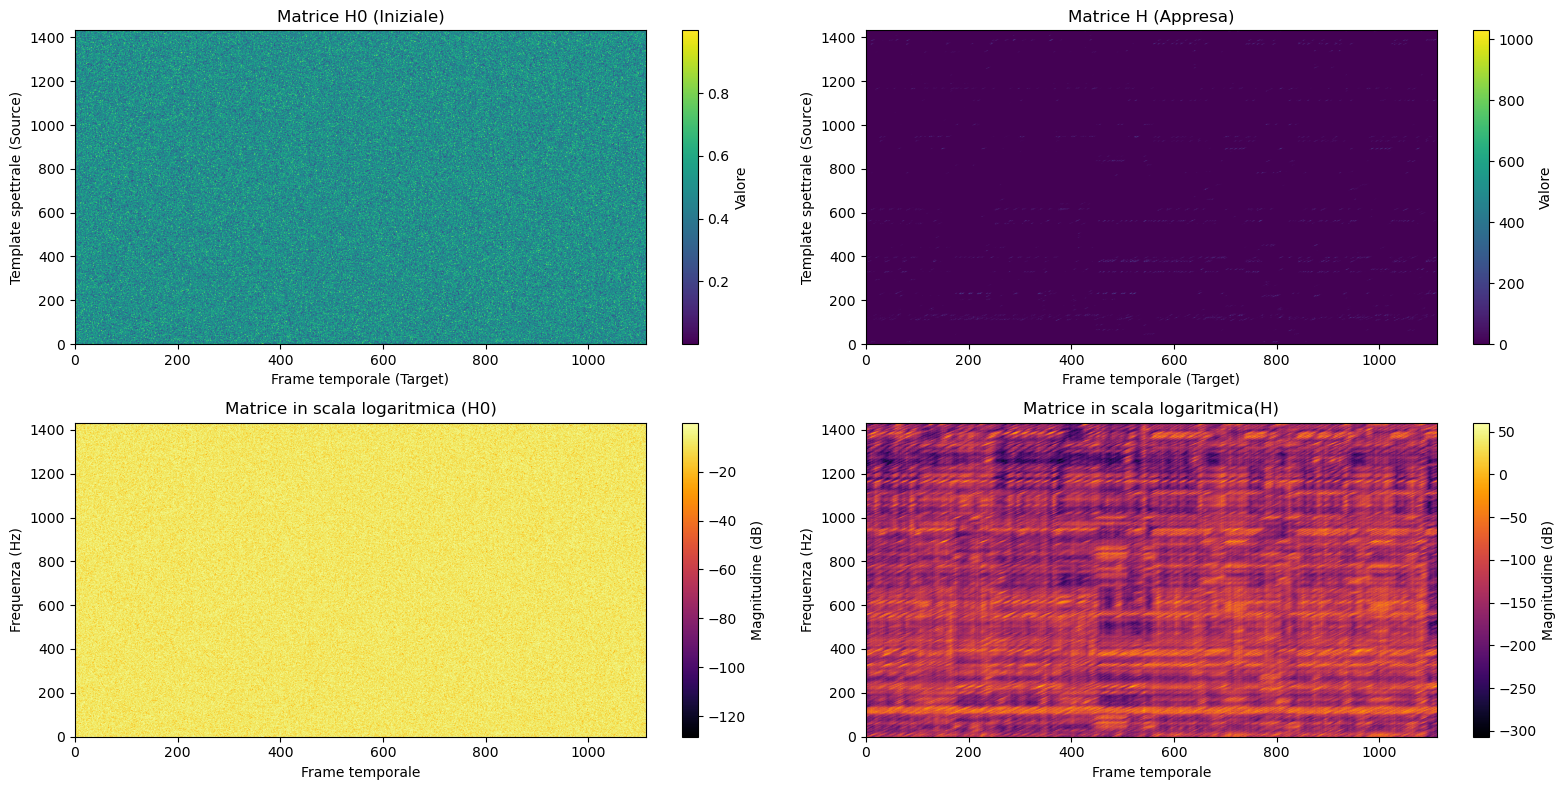

In [86]:
# Plot H0 and H
# 6. Plot della matrice di attivazione (H0 e H)
plt.figure(figsize=(16, 8))

# Matrice H0 (iniziale)
plt.subplot(2, 2, 1)
plt.title("Matrice H0 (Iniziale)")
plt.imshow(H0, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Valore")
plt.xlabel("Frame temporale (Target)")
plt.ylabel("Template spettrale (Source)")

# Matrice H (appresa)
plt.subplot(2, 2, 2)
plt.title("Matrice H (Appresa)")
plt.imshow(H, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Valore")
plt.xlabel("Frame temporale (Target)")
plt.ylabel("Template spettrale (Source)")

# Magnitudine originale del target
plt.subplot(2, 2, 3)
plt.title("Matrice in scala logaritmica (H0)")
plt.imshow(20 * np.log10(H0 + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitudine (dB)")
plt.xlabel("Frame temporale")
plt.ylabel("Frequenza (Hz)")

# Magnitudine approssimata
plt.subplot(2, 2, 4)
plt.title("Matrice in scala logaritmica(H)")
plt.imshow(20 * np.log10(H + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitudine (dB)")
plt.xlabel("Frame temporale")
plt.ylabel("Frequenza (Hz)")

plt.tight_layout()
plt.show()




In [87]:
def visualize_nmf_with_time_axis(Y_target, W, H, fs, time_res, gamma=2):
    """
    Visualizza i risultati della NMF utilizzando l'asse temporale e il fattore di compressione gamma.
    Plotta la matrice di attivazione (H), i template spettrali (W), la magnitudine approssimata (V_approx),
    e la magnitudine originale del target (Y_target).

    Args:
        Y_target (np.ndarray): Magnitudine STFT del target.
        W (np.ndarray): Matrice dei template spettrali.
        H (np.ndarray): Matrice di attivazione.
        fs (int): Frequenza di campionamento.
        time_res (float): Risoluzione temporale in secondi.
        gamma (float): Fattore di compressione.
    """
    # Calcolo dell'approssimazione
    V_approx = np.dot(W, H)

    # Calcolo degli assi temporali e di frequenza
    time_axis = np.arange(Y_target.shape[1]) * time_res  # Asse temporale
    freq_axis = np.arange(Y_target.shape[0]) * (fs / W.shape[0])  # Asse delle frequenze
    freq_limit = 2000  # Limite di frequenza (Hz)
    freq_bins = np.sum(freq_axis <= freq_limit)  # Bin di frequenza entro il limite

    # Estensione per le immagini
    x_ext = time_res / 2
    y_ext = (freq_axis[1] - freq_axis[0]) / 2
    image_extent = [time_axis[0] - x_ext, time_axis[-1] + x_ext, freq_axis[0] - y_ext, freq_axis[freq_bins - 1] + y_ext]

    # Creazione della figura
    plt.figure(figsize=(18, 12))

    # 1. Plot della matrice H compressa
    plt.subplot(2, 2, 1)
    plt.title("Matrice H (Compressa)")
    plt.imshow(H ** gamma, aspect='auto', origin='lower', cmap='viridis',
               extent=[time_axis[0] - x_ext, time_axis[-1] + x_ext, 0, H.shape[0]])
    plt.colorbar(label="Attivazione (Compressa)")
    plt.xlabel("Tempo (secondi)")
    plt.ylabel("Template spettrale")

    # 2. Plot della matrice W compressa
    plt.subplot(2, 2, 2)
    plt.title("Matrice W (Compressa)")
    plt.imshow(W[:freq_bins, :] ** gamma, aspect='auto', origin='lower', cmap='viridis',
               extent=[0, W.shape[1], freq_axis[0] - y_ext, freq_axis[freq_bins - 1] + y_ext])
    plt.colorbar(label="Magnitudine (Compressa)")
    plt.xlabel("Template spettrale")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_limit])

    # 3. Plot della magnitudine approssimata compressa
    plt.subplot(2, 2, 3)
    plt.title("Magnitudine approssimata (Compressa)")
    plt.imshow(V_approx[:freq_bins, :] ** gamma, aspect='auto', origin='lower', cmap='inferno', extent=image_extent)
    plt.colorbar(label="Magnitudine (Compressa)")
    plt.xlabel("Tempo (secondi)")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_limit])

    # 4. Plot della magnitudine originale compressa
    plt.subplot(2, 2, 4)
    plt.title("Magnitudine originale (Compressa)")
    plt.imshow(Y_target[:freq_bins, :] ** gamma, aspect='auto', origin='lower', cmap='inferno', extent=image_extent)
    plt.colorbar(label="Magnitudine (Compressa)")
    plt.xlabel("Tempo (secondi)")
    plt.ylabel("Frequenza (Hz)")
    plt.ylim([0, freq_limit])

    # Layout e visualizzazione
    plt.tight_layout()
    plt.show()
    

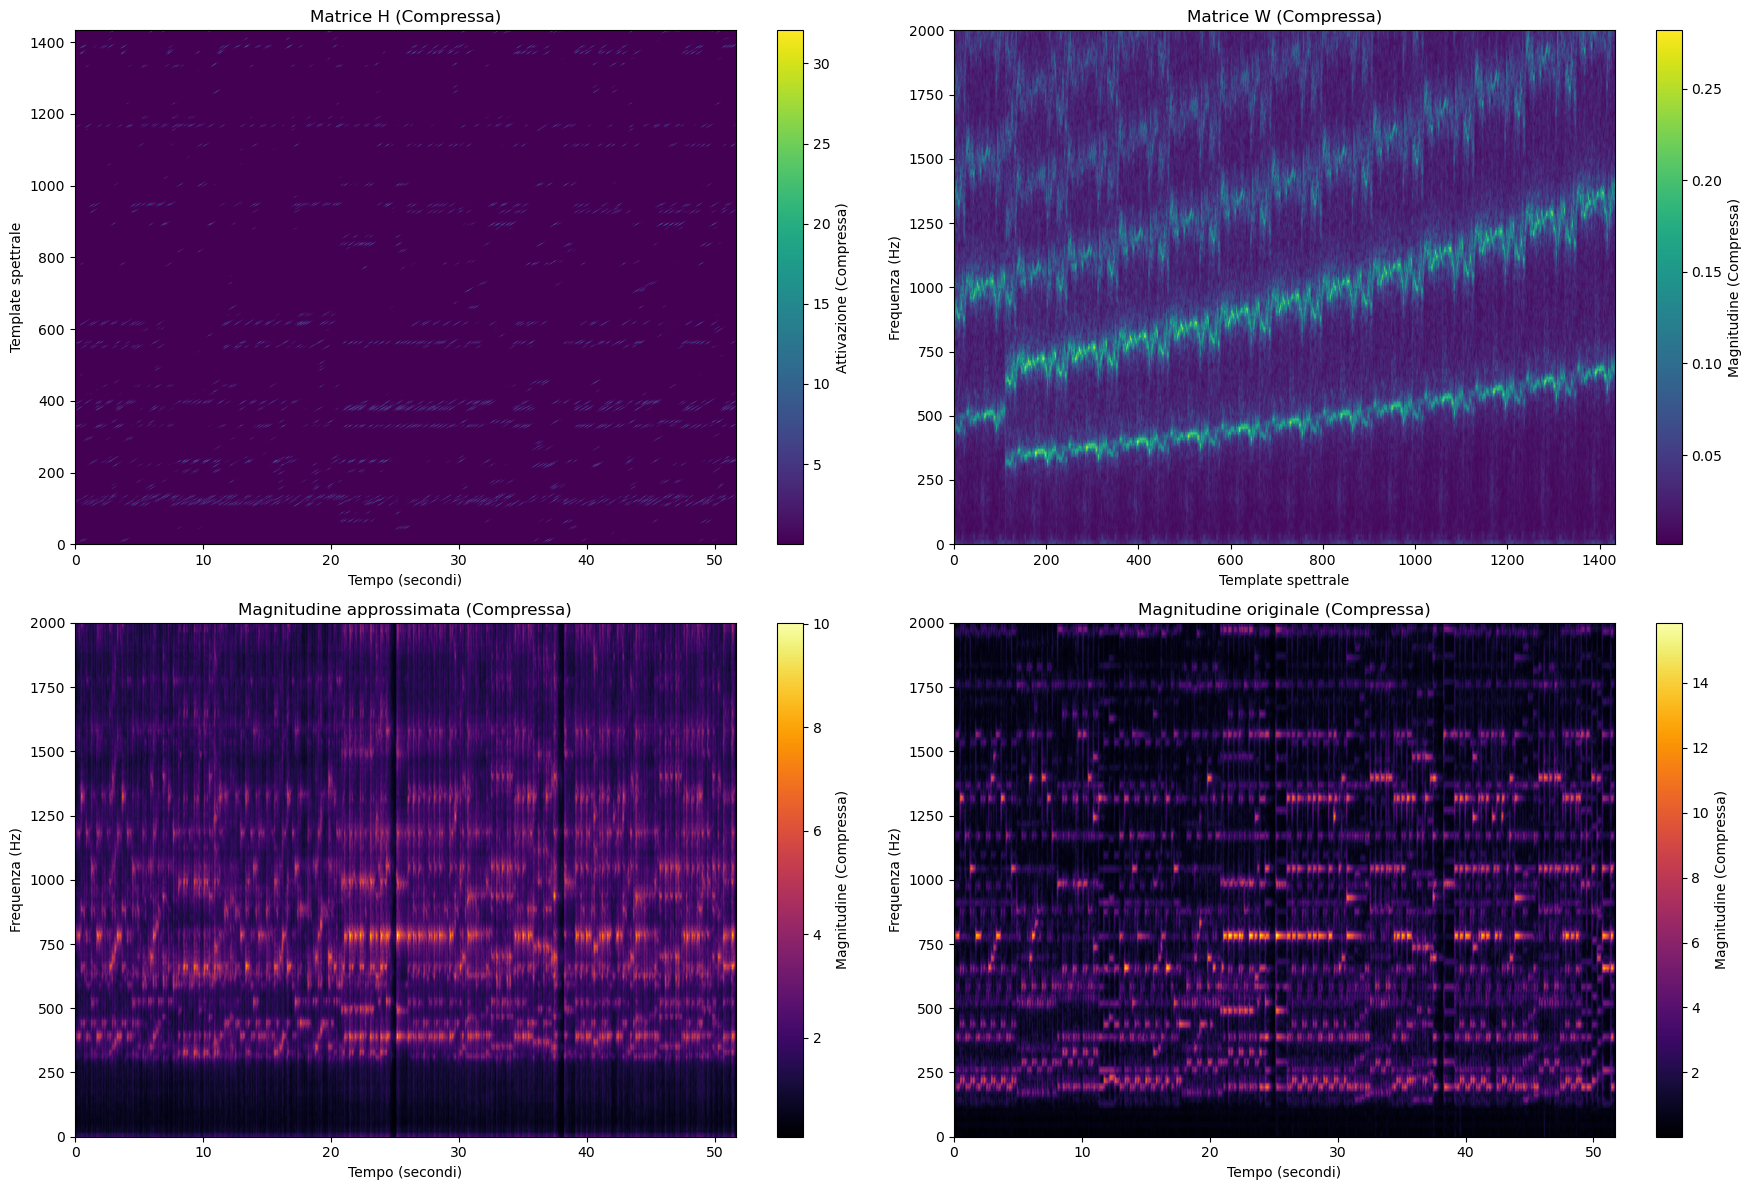

In [88]:
# Test visualize_nmf
# Chiamata della funzione di visualizzazione
visualize_nmf_with_time_axis(Y_target, W, H, Fs, time_res, gamma=0.5 )

## Question 3

In [37]:
# Replace the magnitude frames by complex valued frames


# Re-synthesize using ISTFT


# Re-synthesize using Griffin-Lim algorithm



In [38]:
# Save result


In [39]:
# Phase check 
# ISTFT


# Griffin-Lim


In [40]:
# Play target


In [41]:
# Play source


In [42]:
# Play new target - ISTFT


In [43]:
# Play new target - GF


## Question 4

In [44]:
# Define the function timbre_transfer
def timbre_transfer(t, s, fs, hop_size=1024, win_length=4096, resynth='gf', plot=False):
    """Transfer the timbre from the source to the target

    Args:
        t: target waveform
        s: source waveform
        fs: sampling frequency
        hop_size: hop size used for the STFT computation and the re-synthesis
        win_length: length of the window used for the STFT computation and the re-synthesis
        resynth: method used for the audio re-synthesis. Methods available: 'gf' = Griffin-Lim, 'istft' = Inverse STFT
        plot: boolean enabling visualization of NMF matrices and target spectrogram 

    Returns:
        y: audio waveform resynthesized through the chosen method
    """
    
    return y

## Question 5

In [45]:
# Use the function timbre_tansfer for all the possible combinations of source and target

